# Hyperparameter transfer

## Basic imports

In [1]:
import math
import time
import numpy as np

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms

## Question 1: Spectral norm of Gaussian matrix

In [2]:
d = 100

M = torch.randn(size=(d, d), device="cuda")
spec_norm = torch.linalg.matrix_norm(M, ord=2)

print(spec_norm.item())

19.232627868652344


Fitted scaling rule: alpha = 1.7260283992297267, beta = 0.5269442163363144


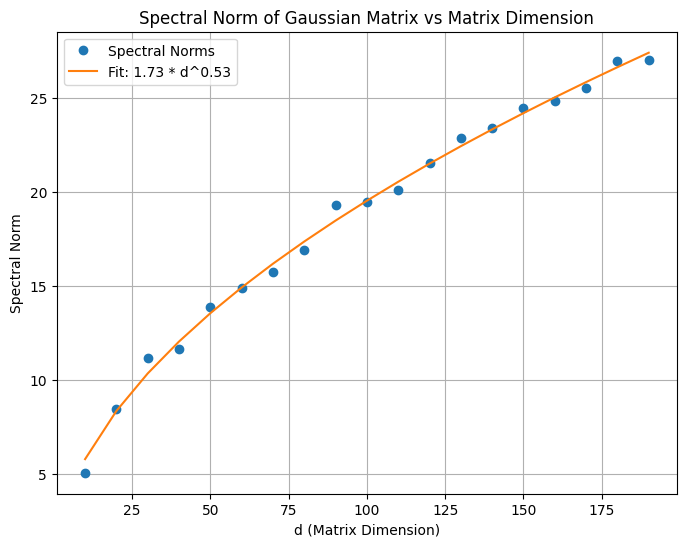

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


# Function to compute spectral norm for different d
def spectral_norm_vs_d(d_values):
    spectral_norms = []
    for d in d_values:
        M = torch.randn(size=(d, d), device="cuda")  # Sample dxd matrix
        spec_norm = torch.linalg.matrix_norm(M, ord=2)  # Compute spectral norm
        spectral_norms.append(spec_norm.item())  # Store the result
    return np.array(spectral_norms)


# Scaling rule: alpha * d^beta
def scaling_rule(d, alpha, beta):
    return alpha * d**beta


# Generate d values and compute spectral norms
d_values = np.arange(10, 200, 10)  # Vary d from 10 to 200 with step size 10
spectral_norms = spectral_norm_vs_d(d_values)

# Fit the scaling rule to the data
params, _ = curve_fit(scaling_rule, d_values, spectral_norms)

# Extract the coefficients alpha and beta
alpha, beta = params
print(f"Fitted scaling rule: alpha = {alpha}, beta = {beta}")

# Plot the spectral norm vs d and fitted curve
plt.figure(figsize=(8, 6))
plt.plot(d_values, spectral_norms, "o", label="Spectral Norms")
plt.plot(
    d_values, scaling_rule(d_values, *params), label=f"Fit: {alpha:.2f} * d^{beta:.2f}"
)
plt.xlabel("d (Matrix Dimension)")
plt.ylabel("Spectral Norm")
plt.title("Spectral Norm of Gaussian Matrix vs Matrix Dimension")
plt.legend()
plt.grid(True)
plt.show()

## Question 2: Spectral norm of orthogonal matrix

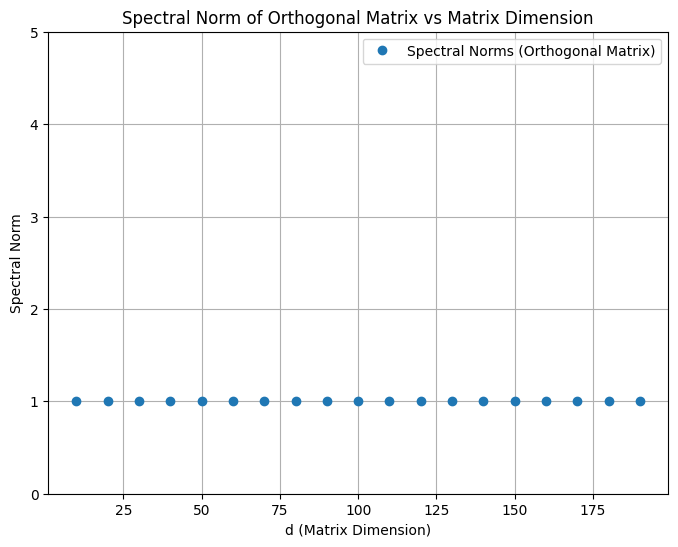

Spectral norm for d=10: 1.000001311302185
Spectral norm for d=20: 1.0000041723251343
Spectral norm for d=30: 1.0000052452087402
Spectral norm for d=40: 1.0000101327896118
Spectral norm for d=50: 1.000015139579773
Spectral norm for d=60: 1.000017523765564
Spectral norm for d=70: 1.0000214576721191
Spectral norm for d=80: 1.0000238418579102
Spectral norm for d=90: 1.000027060508728
Spectral norm for d=100: 1.0000319480895996
Spectral norm for d=110: 1.0000377893447876
Spectral norm for d=120: 1.0000420808792114
Spectral norm for d=130: 1.0000483989715576
Spectral norm for d=140: 1.0000529289245605
Spectral norm for d=150: 1.0000560283660889
Spectral norm for d=160: 1.000056505203247
Spectral norm for d=170: 1.0000687837600708
Spectral norm for d=180: 1.0000747442245483
Spectral norm for d=190: 1.0000721216201782


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.init import orthogonal_


# Function to compute spectral norm for different d (for orthogonal matrices)
def orthogonal_spectral_norm_vs_d(d_values):
    spectral_norms = []
    for d in d_values:
        M = torch.zeros(size=(d, d), device="cuda")  # Initialize matrix
        orthogonal_(M)  # Resample M to be a random semi-orthogonal matrix
        spec_norm = torch.linalg.matrix_norm(M, ord=2)  # Compute spectral norm
        spectral_norms.append(spec_norm.item())  # Store the result
    return np.array(spectral_norms)


# Generate d values and compute spectral norms for orthogonal matrices
d_values = np.arange(10, 200, 10)  # Vary d from 10 to 200 with step size 10
spectral_norms = orthogonal_spectral_norm_vs_d(d_values)

# Plot the spectral norm vs d
plt.figure(figsize=(8, 6))
plt.plot(d_values, spectral_norms, "o", label="Spectral Norms (Orthogonal Matrix)")
plt.xlabel("d (Matrix Dimension)")
plt.ylabel("Spectral Norm")
plt.ylim(0, 5)
plt.title("Spectral Norm of Orthogonal Matrix vs Matrix Dimension")
plt.legend()
plt.grid(True)
plt.show()

# Print the spectral norm for each d
for d, spec_norm in zip(d_values, spectral_norms):
    print(f"Spectral norm for d={d}: {spec_norm}")

## Question 3: Power iteration

In [13]:
def spectral_norm(A, n_steps=10):
    v = torch.randn(A.shape[1], device=A.device)
    for _ in range(n_steps):
        v /= v.norm()
        v = A @ v @ A
    return v.norm().sqrt()


d = 2000
M = torch.randn(size=(d, d), device="cuda")

torch.cuda.synchronize()
t0 = time.time()
spec_norm = spectral_norm(M, 20).item()
t = time.time() - t0
print(f"computed {spec_norm=} in {t=} seconds")

torch.cuda.synchronize()
t0 = time.time()
spec_norm = torch.linalg.matrix_norm(M, ord=2).item()
t = time.time() - t0
print(f"computed {spec_norm=} in {t=} seconds")

computed spec_norm=87.48060607910156 in t=0.004002809524536133 seconds
computed spec_norm=88.97095489501953 in t=0.5920462608337402 seconds


## Question 4: Learning rate transfer across width and depth
You only need to modify the two blocks of code that are marked, and then choose the learning rate `eta` for the large width training run.

In [ ]:
batch_size = 128

mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

trainset = datasets.CIFAR10("./data", train=True, download=True, transform=transform)
testset = datasets.CIFAR10("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, pin_memory=True
)

## Define the MLP architecture

In [ ]:
class MLP(nn.Module):
    def __init__(self, depth, width):
        super(MLP, self).__init__()

        self.initial = nn.Linear(3072, width, bias=False)
        self.layers = nn.ModuleList(
            [nn.Linear(width, width, bias=False) for _ in range(depth - 2)]
        )
        self.final = nn.Linear(width, 10, bias=False)

        self.nonlinearity = lambda x: F.relu(x) * math.sqrt(2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.initial(x)
        x = self.nonlinearity(x)

        for layer in self.layers:
            x = layer(x)
            x = self.nonlinearity(x)

        return self.final(x)

## Define the train and test loop

In [ ]:
def loop(net, train, eta):
    dataloader = train_loader if train else test_loader
    description = "Training... " if train else "Testing... "

    acc_list = []

    for data, target in tqdm(dataloader, desc=description):
        data, target = data.cuda(), target.cuda()
        output = net(data)

        loss = (
            output.logsumexp(dim=1).mean()
            - output[range(target.shape[0]), target].mean()
        )  # cross-entropy loss
        acc = (output.max(dim=1)[1] == target).sum() / target.shape[0]  # accuracy
        acc_list.append(acc.item())

        if train:
            loss.backward()

            for p in net.parameters():
                fan_out, fan_in = p.shape
                update = torch.sign(p.grad)
                ## START BLOCK that you should modify
                update *= 1
                ## END BLOCK that you should modify
                p.data -= eta * update
            net.zero_grad()

    return np.mean(acc_list)

## Sweep the learning rate at small width



In [ ]:
depth = 5
width = 32


def initialize_matrix(p):
    fan_out, fan_in = p.shape
    ## START BLOCK that you should modify ##
    p.data = torch.randn_like(p) / math.sqrt(fan_in)
    ## END BLOCK that you should modify


for eta in [0.0001, 0.001, 0.01, 0.1, 1.0]:
    print(f"Training at {width=}, {depth=}, {eta=}")

    net = MLP(depth, width).cuda()

    print("\nNetwork tensor shapes are:\n")
    for name, p in net.named_parameters():
        print(p.shape, "\t", name)
        initialize_matrix(p)

    train_acc = loop(net, train=True, eta=eta)
    test_acc = loop(net, train=False, eta=None)

    print(f"\nWe achieved train acc={train_acc:.3f} and test acc={test_acc:.3f}\n")
    print("===================================================================\n")

## Run the best learning rate at large width

In [ ]:
depth = 5
width = 4096

# START BLOCK you should set this to the best value of eta from the previous cell
eta = 0.001
# END BLOCK

print(f"Training at {width=}, {depth=}, {eta=}")

net = MLP(depth, width).cuda()

print("\nNetwork tensor shapes are:\n")
for name, p in net.named_parameters():
    print(p.shape, "\t", name)
    initialize_matrix(p)

train_acc = loop(net, train=True, eta=eta)
test_acc = loop(net, train=False, eta=None)

print(f"\nWe achieved train acc={train_acc:.3f} and test acc={test_acc:.3f}\n")
print("===================================================================\n")